In [26]:

import numpy as np 
import pandas as pd

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("pastel")

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [28]:
df = pd.read_csv('CO2 Emissions.csv')
df.columns = df.columns.str.replace(' ', '')
df.head()

,Make,Model,VehicleClass,EngineSize(L),Cylinders,Transmission,FuelType,FuelConsumptionCity(L/100km),FuelConsumptionHwy(L/100km),FuelConsumptionComb(L/100km),FuelConsumptionComb(mpg),CO2Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Make                          7385 non-null   object 
 1   Model                         7385 non-null   object 
 2   VehicleClass                  7385 non-null   object 
 3   EngineSize(L)                 7385 non-null   float64
 4   Cylinders                     7385 non-null   int64  
 5   Transmission                  7385 non-null   object 
 6   FuelType                      7385 non-null   object 
 7   FuelConsumptionCity(L/100km)  7385 non-null   float64
 8   FuelConsumptionHwy(L/100km)   7385 non-null   float64
 9   FuelConsumptionComb(L/100km)  7385 non-null   float64
 10  FuelConsumptionComb(mpg)      7385 non-null   int64  
 11  CO2Emissions(g/km)            7385 non-null   int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 692.5+ KB


In [30]:
df.isna().sum()

Make                            0
Model                           0
VehicleClass                    0
EngineSize(L)                   0
Cylinders                       0
Transmission                    0
FuelType                        0
FuelConsumptionCity(L/100km)    0
FuelConsumptionHwy(L/100km)     0
FuelConsumptionComb(L/100km)    0
FuelConsumptionComb(mpg)        0
CO2Emissions(g/km)              0
dtype: int64

In [31]:
df.groupby('VehicleClass').aggregate({'CO2Emissions(g/km)': 'mean', 'Model': 'count'})

,CO2Emissions(g/km),Model
VehicleClass,,
COMPACT,216.679061,1022
FULL-SIZE,263.316119,639
MID-SIZE,222.455428,1133
MINICOMPACT,236.607362,326
MINIVAN,262.312500,80
PICKUP TRUCK - SMALL,278.968553,159
PICKUP TRUCK - STANDARD,301.513011,538
SPECIAL PURPOSE VEHICLE,237.597403,77
STATION WAGON - MID-SIZE,238.698113,53


In [32]:
df.groupby('FuelType').aggregate({'CO2Emissions(g/km)': 'mean', 'Model': 'count'})

,CO2Emissions(g/km),Model
FuelType,,
D,237.548571,175
E,275.091892,370
N,213.000000,1
X,235.119329,3637
Z,266.043410,3202


In [33]:
df = df[df.FuelType != 'N'].reset_index(drop=True)

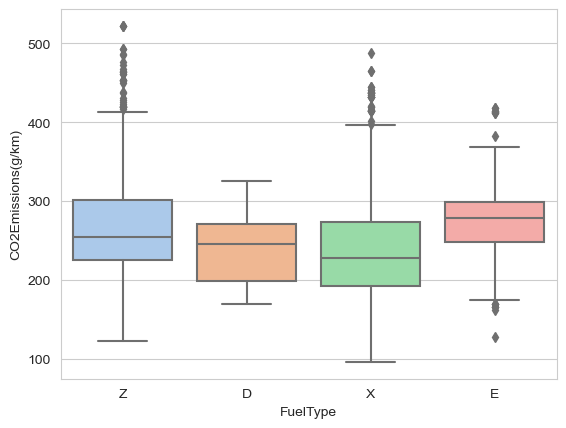

In [34]:
plt.figure()
sns.boxplot(data = df, x = 'FuelType', y = 'CO2Emissions(g/km)')
plt.show()

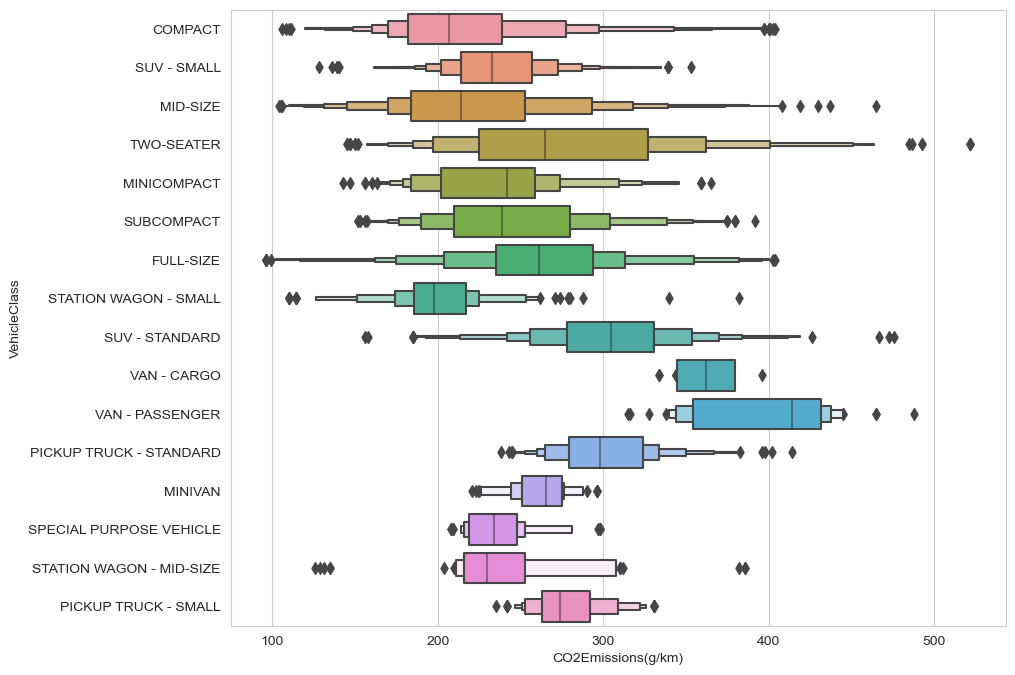

In [35]:
plt.figure(figsize=(10,8))
sns.boxenplot(data = df, x = 'CO2Emissions(g/km)', y = 'VehicleClass')
plt.show()

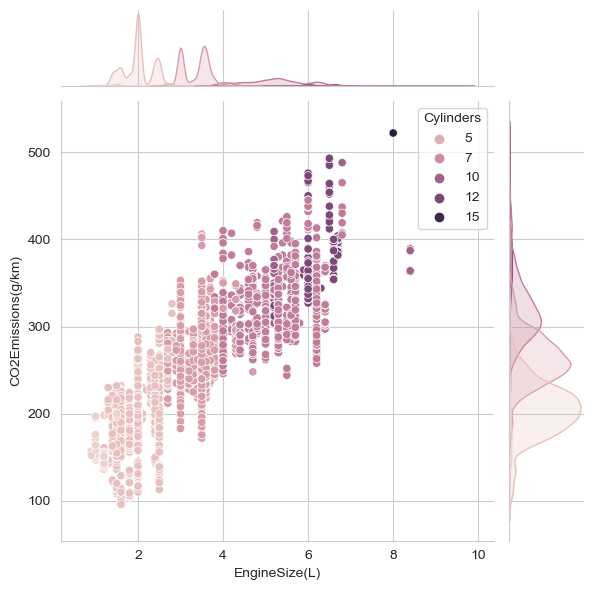

In [36]:
sns.jointplot(data = df, x ='EngineSize(L)', y = 'CO2Emissions(g/km)', hue = 'Cylinders')
plt.show()

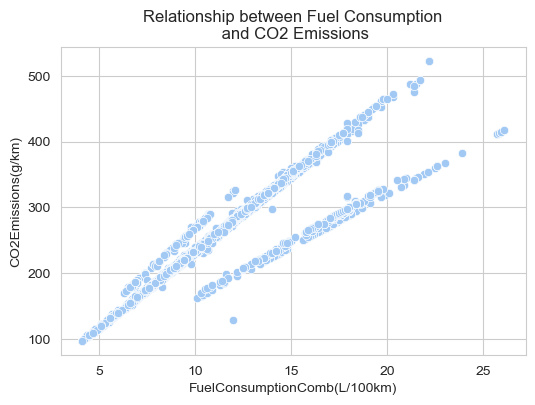

In [37]:
plt.figure(figsize=(6,4))
sns.scatterplot(data = df, x = 'FuelConsumptionComb(L/100km)', y = 'CO2Emissions(g/km)')
plt.title("Relationship between Fuel Consumption\n and CO2 Emissions")
plt.show()

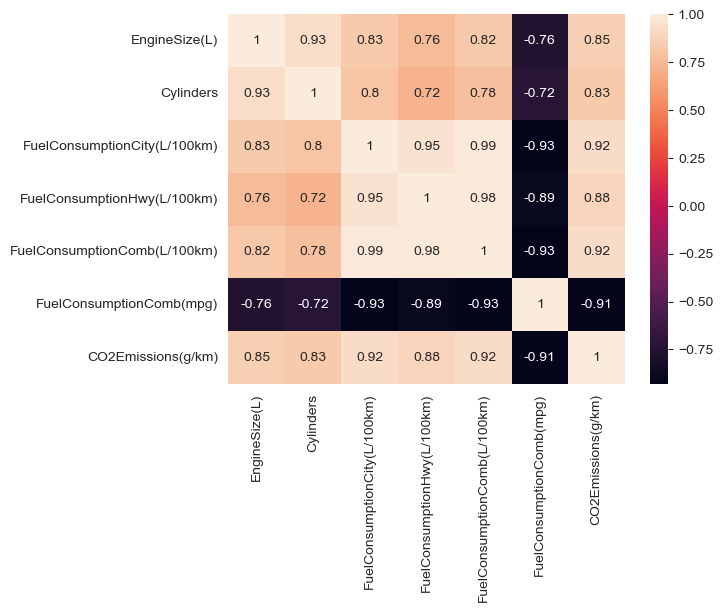

In [38]:
sns.heatmap(df.corr(numeric_only = True).round(2), annot = True)
plt.show()

In [39]:
predictors = ['VehicleClass', 'EngineSize(L)', 'Cylinders', 'FuelType', 'FuelConsumptionComb(L/100km)']
target = 'CO2Emissions(g/km)'

split = StratifiedShuffleSplit(n_splits = 1, train_size = 0.8, random_state = 42)

for train_index, test_index in split.split(df, df['VehicleClass']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]
    
strat_train_set.head()


X_train = strat_train_set[predictors].copy()
y_train = np.array(strat_train_set[target].copy())

X_test = strat_test_set[predictors].copy()
y_test = np.array(strat_test_set[target].copy())

In [40]:
pca = PCA(n_components = 1, random_state = 42)
pca.fit(X_train[['EngineSize(L)', 'Cylinders', 'FuelConsumptionComb(L/100km)']])
print("These three components explain {:.2f}% of the variance".format(pca.explained_variance_ratio_[0] * 100))

These three components explain 89.88% of the variance


In [41]:
one_hot = OneHotEncoder()
one_hot.fit(X_train[['VehicleClass', 'FuelType']])
one_hot.categories_

[array(['COMPACT', 'FULL-SIZE', 'MID-SIZE', 'MINICOMPACT', 'MINIVAN',
        'PICKUP TRUCK - SMALL', 'PICKUP TRUCK - STANDARD',
        'SPECIAL PURPOSE VEHICLE', 'STATION WAGON - MID-SIZE',
        'STATION WAGON - SMALL', 'SUBCOMPACT', 'SUV - SMALL',
        'SUV - STANDARD', 'TWO-SEATER', 'VAN - CARGO', 'VAN - PASSENGER'],
       dtype=object),
 array(['D', 'E', 'X', 'Z'], dtype=object)]

In [42]:
one_hot.fit_transform(X_train[['VehicleClass', 'FuelType']]).toarray()

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.]])

In [43]:
num_pipeline = Pipeline([
    ('pca', PCA(n_components=1, random_state=42)), 
    ('scaler', StandardScaler())
])

X_num_tr = num_pipeline.fit_transform(X_train[['EngineSize(L)', 'Cylinders', 'FuelConsumptionComb(L/100km)']])
X_num_tr[0:5]

array([[ 0.35842975],
       [ 0.24062158],
       [ 1.52966016],
       [-0.28472617],
       [ 0.07770434]])

In [44]:
num_attribs = ['EngineSize(L)', 'Cylinders', 'FuelConsumptionComb(L/100km)']
cat_attribs = ['VehicleClass', 'FuelType']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

X_train_prepared = full_pipeline.fit_transform(X_train).toarray()
X_train_prepared

array([[ 0.35842975,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.24062158,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 1.52966016,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.22766749,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [-0.02792679,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-0.77119541,  1.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

In [45]:
# fit test dataset using pipeline
x_test_prepared = full_pipeline.fit_transform(X_test).toarray()
x_test_prepared[0:5]

array([[ 0.90867826,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ],
       [-0.26313944,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [-0.11057271,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ],
       [ 0.2105388 ,  0.        ,  0.        ,  0.        

In [46]:
rf = RandomForestRegressor(n_estimators = 100, max_depth = 7, min_samples_split = 20)
rf.fit(X_train_prepared, y_train)

RandomForestRegressor(max_depth=7, min_samples_split=20)

In [47]:
predictions = rf.predict(x_test_prepared)

rf_error = mean_absolute_error(y_test, predictions)
rf_error

rf_acc= 100 - rf_error
print("Error = ", rf_error)
print("Accuracy = ", rf_acc)




Error =  6.348910751647497
Accuracy =  93.6510892483525


In [48]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)

LinearRegression()

In [49]:
lin_reg_predictions = lin_reg.predict(x_test_prepared)

lin_error = mean_absolute_error(y_test, lin_reg_predictions)
lin_error
lin_acc= 100 - lin_error
print("Error = ", lin_error)
print("Accuracy = ", lin_acc)


Error =  8.397104908845185
Accuracy =  91.60289509115482


In [50]:
ridge = Ridge(alpha=5)
ridge.fit(X_train_prepared, y_train)

Ridge(alpha=5)

In [51]:
ridge_predictions = ridge.predict(x_test_prepared)

ridge_error = mean_absolute_error(y_test, ridge_predictions)
ridge_error
ridge_acc= 100 - ridge_error
print("Error = ", ridge_error)
print("Accuracy = ", ridge_acc)


Error =  8.41396459523984
Accuracy =  91.58603540476017


In [52]:
from sklearn.ensemble import RandomForestRegressor
dtr= RandomForestRegressor(random_state=0)
dtr.fit(X_train_prepared, y_train)

RandomForestRegressor(random_state=0)

In [53]:
dtr_predictions = dtr.predict(x_test_prepared)

dtr_error = mean_absolute_error(y_test, dtr_predictions)
dtr_error
dtr_acc= 100- dtr_error
print("Error = ", dtr_error)
print("Accuracy = ", dtr_acc)

Error =  6.170865996374138
Accuracy =  93.82913400362587


In [54]:
tf.random.set_seed(42)

model = Sequential([
    Dense(75, activation = 'linear', kernel_regularizer=tf.keras.regularizers.l2(.05)),
    Dense(50, activation = 'linear', kernel_regularizer=tf.keras.regularizers.l2(.05)),
    Dense(25, activation = 'linear', kernel_regularizer=tf.keras.regularizers.l2(.05)),
    Dense(1, activation = 'linear', kernel_regularizer=tf.keras.regularizers.l2(.05))
])


model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = .01),
    loss='mean_absolute_error'
)

history = model.fit(
    X_train_prepared,
    y_train,
    epochs = 1000,
    verbose = 0, 
    validation_split = .2 
)

In [55]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
995,10.972745,11.012655,995
996,10.884092,10.921502,996
997,10.903872,11.003953,997
998,11.005595,10.910498,998
999,11.047332,11.197903,999


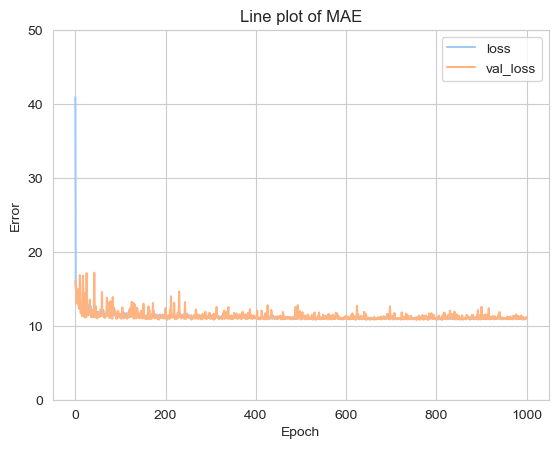

In [56]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 50])

plt.title("Line plot of MAE")
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

In [57]:
tf_predictions = model.predict(x_test_prepared)

tf_error = mean_absolute_error(y_test, tf_predictions)
tf_error
tf_acc= 100 - tf_error
print("Error = ", tf_error)
print("Accuracy = ", tf_acc)


47/47 [==============================] - 0s 627us/step
Error =  8.819464237365516
Accuracy =  91.18053576263449


In [58]:
x_test = strat_test_set[predictors].copy()
y_test = strat_test_set[target].copy()
df_test = pd.merge(x_test, y_test, how = 'inner', left_index = True, right_index = True)
df_test['RF_Pred'] = predictions.round(2)
df_test['LinReg_Pred'] = lin_reg_predictions.round(2)
df_test['Ridge_Pred'] = ridge_predictions.round(2)
df_test['NN_Pred'] = tf_predictions.round(2)
df_test

,VehicleClass,EngineSize(L),Cylinders,FuelType,FuelConsumptionComb(L/100km),CO2Emissions(g/km),RF_Pred,LinReg_Pred,Ridge_Pred,NN_Pred
2437,FULL-SIZE,3.6,6,E,14.5,239,232.01,226.53,227.89,229.119995
5755,PICKUP TRUCK - STANDARD,3.0,6,D,9.7,260,261.75,260.76,259.51,255.580002
5585,MID-SIZE,3.6,6,X,10.1,238,237.98,239.04,239.11,234.460007
4214,MINICOMPACT,3.8,6,Z,11.4,267,268.95,261.84,261.97,258.429993
1166,COMPACT,2.0,4,Z,8.4,193,198.77,197.09,197.13,197.039993
...,...,...,...,...,...,...,...,...,...,...
1481,SUBCOMPACT,1.6,4,X,8.0,184,184.59,186.82,187.06,186.130005
7163,STATION WAGON - SMALL,3.0,6,Z,10.8,255,253.03,254.43,254.41,252.649994
6283,SPECIAL PURPOSE VEHICLE,2.0,4,X,9.3,218,208.77,224.30,223.38,221.970001
4098,TWO-SEATER,4.7,8,Z,11.7,275,281.32,290.98,291.03,287.619995


In [59]:
eval_metrics = pd.DataFrame(data = [rf_error, lin_error, ridge_error, tf_error, dtr_error],
                            columns = ['Avg. Error'],
                            index = ['RF Error', 'LinReg Error', 'Ridge Error', 'Neural Net Error', 'Decision Tree Error'])
eval_metrics

,Avg. Error
RF Error,6.348911
LinReg Error,8.397105
Ridge Error,8.413965
Neural Net Error,8.819464
Decision Tree Error,6.170866


In [60]:
eval_metrics = pd.DataFrame(data = [rf_acc, lin_acc, ridge_acc, tf_acc, dtr_acc],
                            columns = ['Accuracy'],
                            index = ['RF Error', 'LinReg Error', 'Ridge Error', 'Neural Net Error', 'Decision Tree Error'])
eval_metrics

,Accuracy
RF Error,93.651089
LinReg Error,91.602895
Ridge Error,91.586035
Neural Net Error,91.180536
Decision Tree Error,93.829134
